Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from glob import glob


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin_cancer_ISIC/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/CNN_assignment/Skin_cancer_ISIC/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
class_name = train_ds.class_names

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

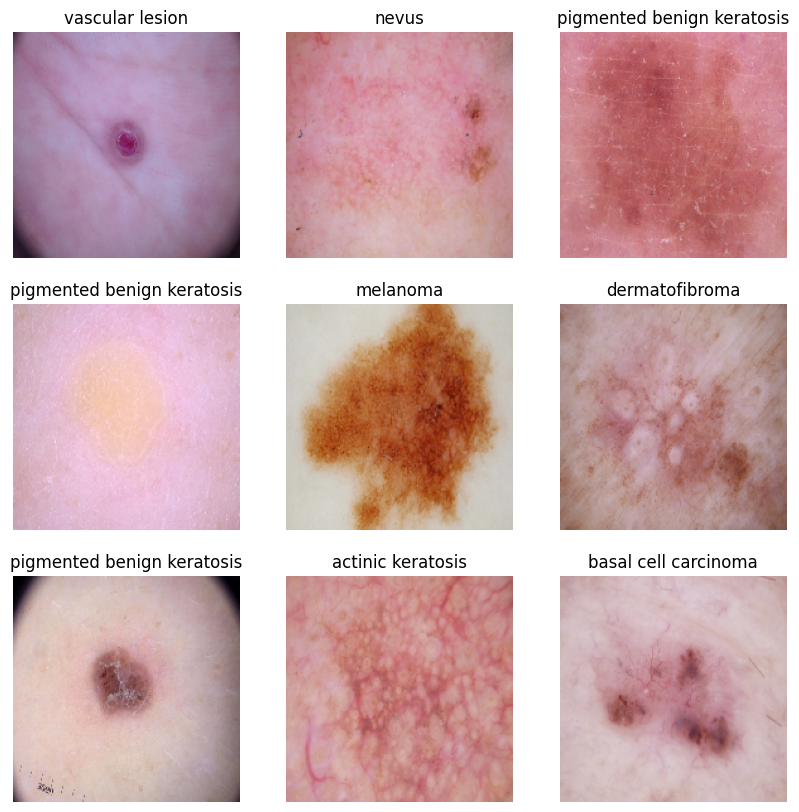

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
input_shape = (img_height, img_width,3)
def CustomModel(inputshape):
  model = Sequential()
  model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape))
  # Block1
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))

  # Block2
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))

  # Block3
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))

  # Block 4
  model.add(Conv2D(256, (3, 3), activation='relu'))
  model.add(Conv2D(256, (3, 3), activation='relu'))
  model.add(MaxPool2D((2, 2), strides=(2, 2)))

  # Dense layers
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(9))
  model.add(Activation('softmax'))
  return model

my_model = CustomModel(input_shape)
# Display the model summary
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrap  (None, 178, 178, 32)      896       
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 176, 176, 32)      9248      
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 88, 88, 32)        0         
 apper)                                                          
                                                                 
 module_wrapper_3 (ModuleWr  (None, 86, 86, 64)        18496     
 apper)                                                 

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [13]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
my_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In [14]:
# View the summary of all layers
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrap  (None, 178, 178, 32)      896       
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 176, 176, 32)      9248      
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 88, 88, 32)        0         
 apper)                                                          
                                                                 
 module_wrapper_3 (ModuleWr  (None, 86, 86, 64)        18496     
 apper)                                                 

### Train the model

In [15]:
epochs = 20
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)
history = my_model.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])

Epoch 1/20
56/56 [==============================] - 394s 2s/step - loss: 2.0404 - accuracy: 0.1897 - val_loss: 1.9806 - val_accuracy: 0.2752 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 5s 82ms/step - loss: 1.8612 - accuracy: 0.2980 - val_loss: 1.7604 - val_accuracy: 0.3400 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 5s 81ms/step - loss: 1.8499 - accuracy: 0.3025 - val_loss: 1.7326 - val_accuracy: 0.3311 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 5s 82ms/step - loss: 1.6951 - accuracy: 0.3677 - val_loss: 1.6292 - val_accuracy: 0.4027 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 5s 82ms/step - loss: 1.6280 - accuracy: 0.3929 - val_loss: 1.6158 - val_accuracy: 0.3982 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 5s 81ms/step - loss: 1.6715 - accuracy: 0.3856 - val_loss: 1.8289 - val_accuracy: 0.3311 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 5s 83ms/step - loss: 1.6

### Visualizing training results

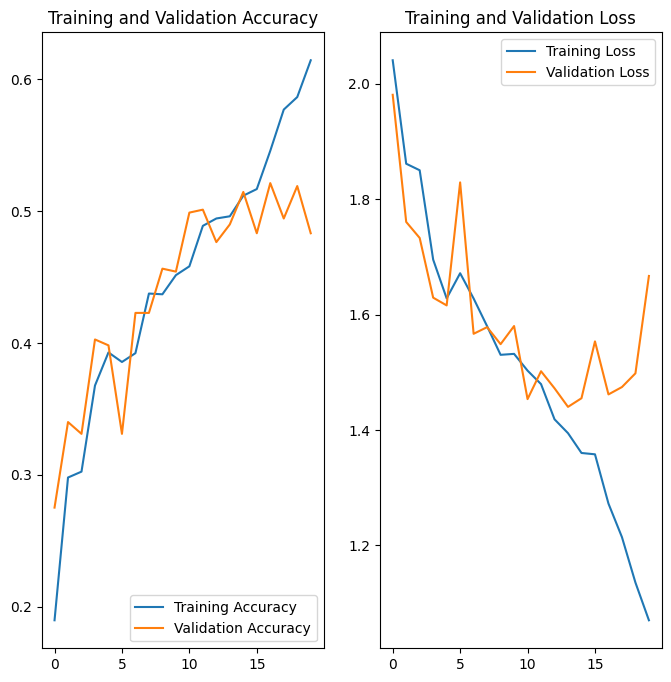

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit


*From the training loss and accuracy metrics, it's evident that the model is learning effectively. However, the validation accuracy and loss metrics indicate poor performance, suggesting overfitting*

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = class_names

train_batches = datagen.flow_from_directory(data_dir_train,
    target_size = (180,180),
    classes = image_class,
    batch_size = 32,
    seed=123,
    class_mode = 'sparse'
 )


Found 2239 images belonging to 9 classes.


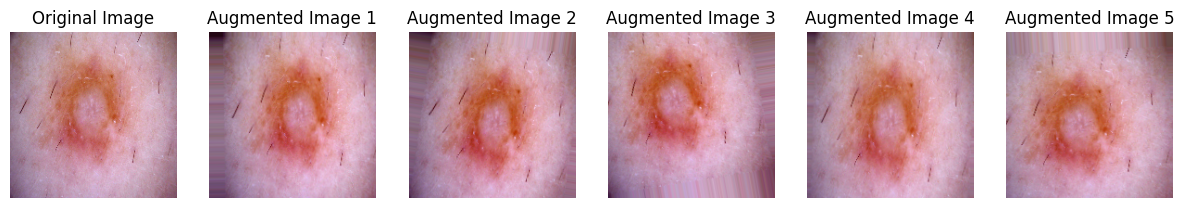

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# Load an example image from your dataset
for images, labels in train_ds.take(1):  # take 1 batch
    # Access the first image in the batch
    x = images[0]

# Generate augmented images
augmented_images = []
# Define the number of augmented images you want to generate for visualization
num_augmented_images = 5
x = np.expand_dims(x, axis=0)  # add batch dimension
for i in range(num_augmented_images):
    augmented_img = datagen.flow(x, batch_size=1)
    augmented_images.append(augmented_img[0][0])  # retrieve the first augmented image from the batch

# Visualize the original and augmented images
plt.figure(figsize=(15, 6))
plt.subplot(1, num_augmented_images+1, 1)
plt.imshow(image.array_to_img(x[0]))
plt.title('Original Image')
plt.axis('off')

for i in range(num_augmented_images):
    plt.subplot(1, num_augmented_images+1, i+2)
    plt.imshow(image.array_to_img(augmented_images[i]))
    plt.title('Augmented Image {}'.format(i+1))
    plt.axis('off')

plt.show()

### Todo:
### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

input_shape = (img_height, img_width,3)
def CustomModel(inputshape):
  model = Sequential()
  model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape))
  # Block1
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))

  # Block2
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Dropout(0.25))
  model.add(MaxPool2D(pool_size=(2, 2)))

  # Block3
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(Dropout(0.25))
  model.add(MaxPool2D(pool_size=(2, 2)))

  # Block 4
  model.add(Conv2D(256, (3, 3), activation='relu'))
  model.add(Conv2D(256, (3, 3), activation='relu'))
  model.add(Dropout(0.25))
  model.add(MaxPool2D((2, 2), strides=(2, 2)))

  # Dense layers
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(9))
  model.add(Activation('softmax'))
  return model

my_model = CustomModel(input_shape)
# Display the model summary
my_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_17 (ModuleW  (None, 178, 178, 32)      896       
 rapper)                                                         
                                                                 
 module_wrapper_18 (ModuleW  (None, 176, 176, 32)      9248      
 rapper)                                                         
                                                                 
 module_wrapper_19 (ModuleW  (None, 88, 88, 32)        0         
 rapper)                                                         
                                                                 
 module_wrapper_20 (ModuleW  (None, 86, 86, 64)        18496     
 rapper)                                              

### Compiling the model

In [20]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
my_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

### Training the model

In [21]:
epochs = 20
history = my_model.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])

Epoch 1/20
56/56 [==============================] - 12s 117ms/step - loss: 2.0525 - accuracy: 0.1830 - val_loss: 2.0378 - val_accuracy: 0.1499 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 6s 112ms/step - loss: 2.0302 - accuracy: 0.2087 - val_loss: 2.0249 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 6s 112ms/step - loss: 2.0370 - accuracy: 0.1903 - val_loss: 2.0277 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 6s 111ms/step - loss: 2.0274 - accuracy: 0.1975 - val_loss: 2.0225 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - ETA: 0s - loss: 2.0341 - accuracy: 0.1830
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
56/56 [==============================] - 6s 110ms/step - loss: 2.0341 - accuracy: 0.1830 - val_loss: 2.0181 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 6s 112ms/step

### Visualizing the results

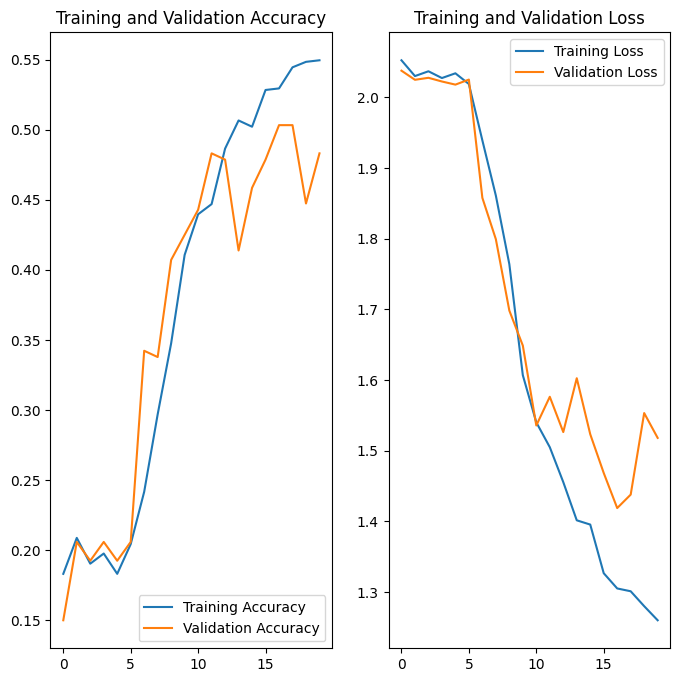

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
> *The current model is learning more efficiently than the previous one. Both the training loss and validation loss are decreasing and the accuracy are increasing.*

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 1000x1000 with 0 Axes>

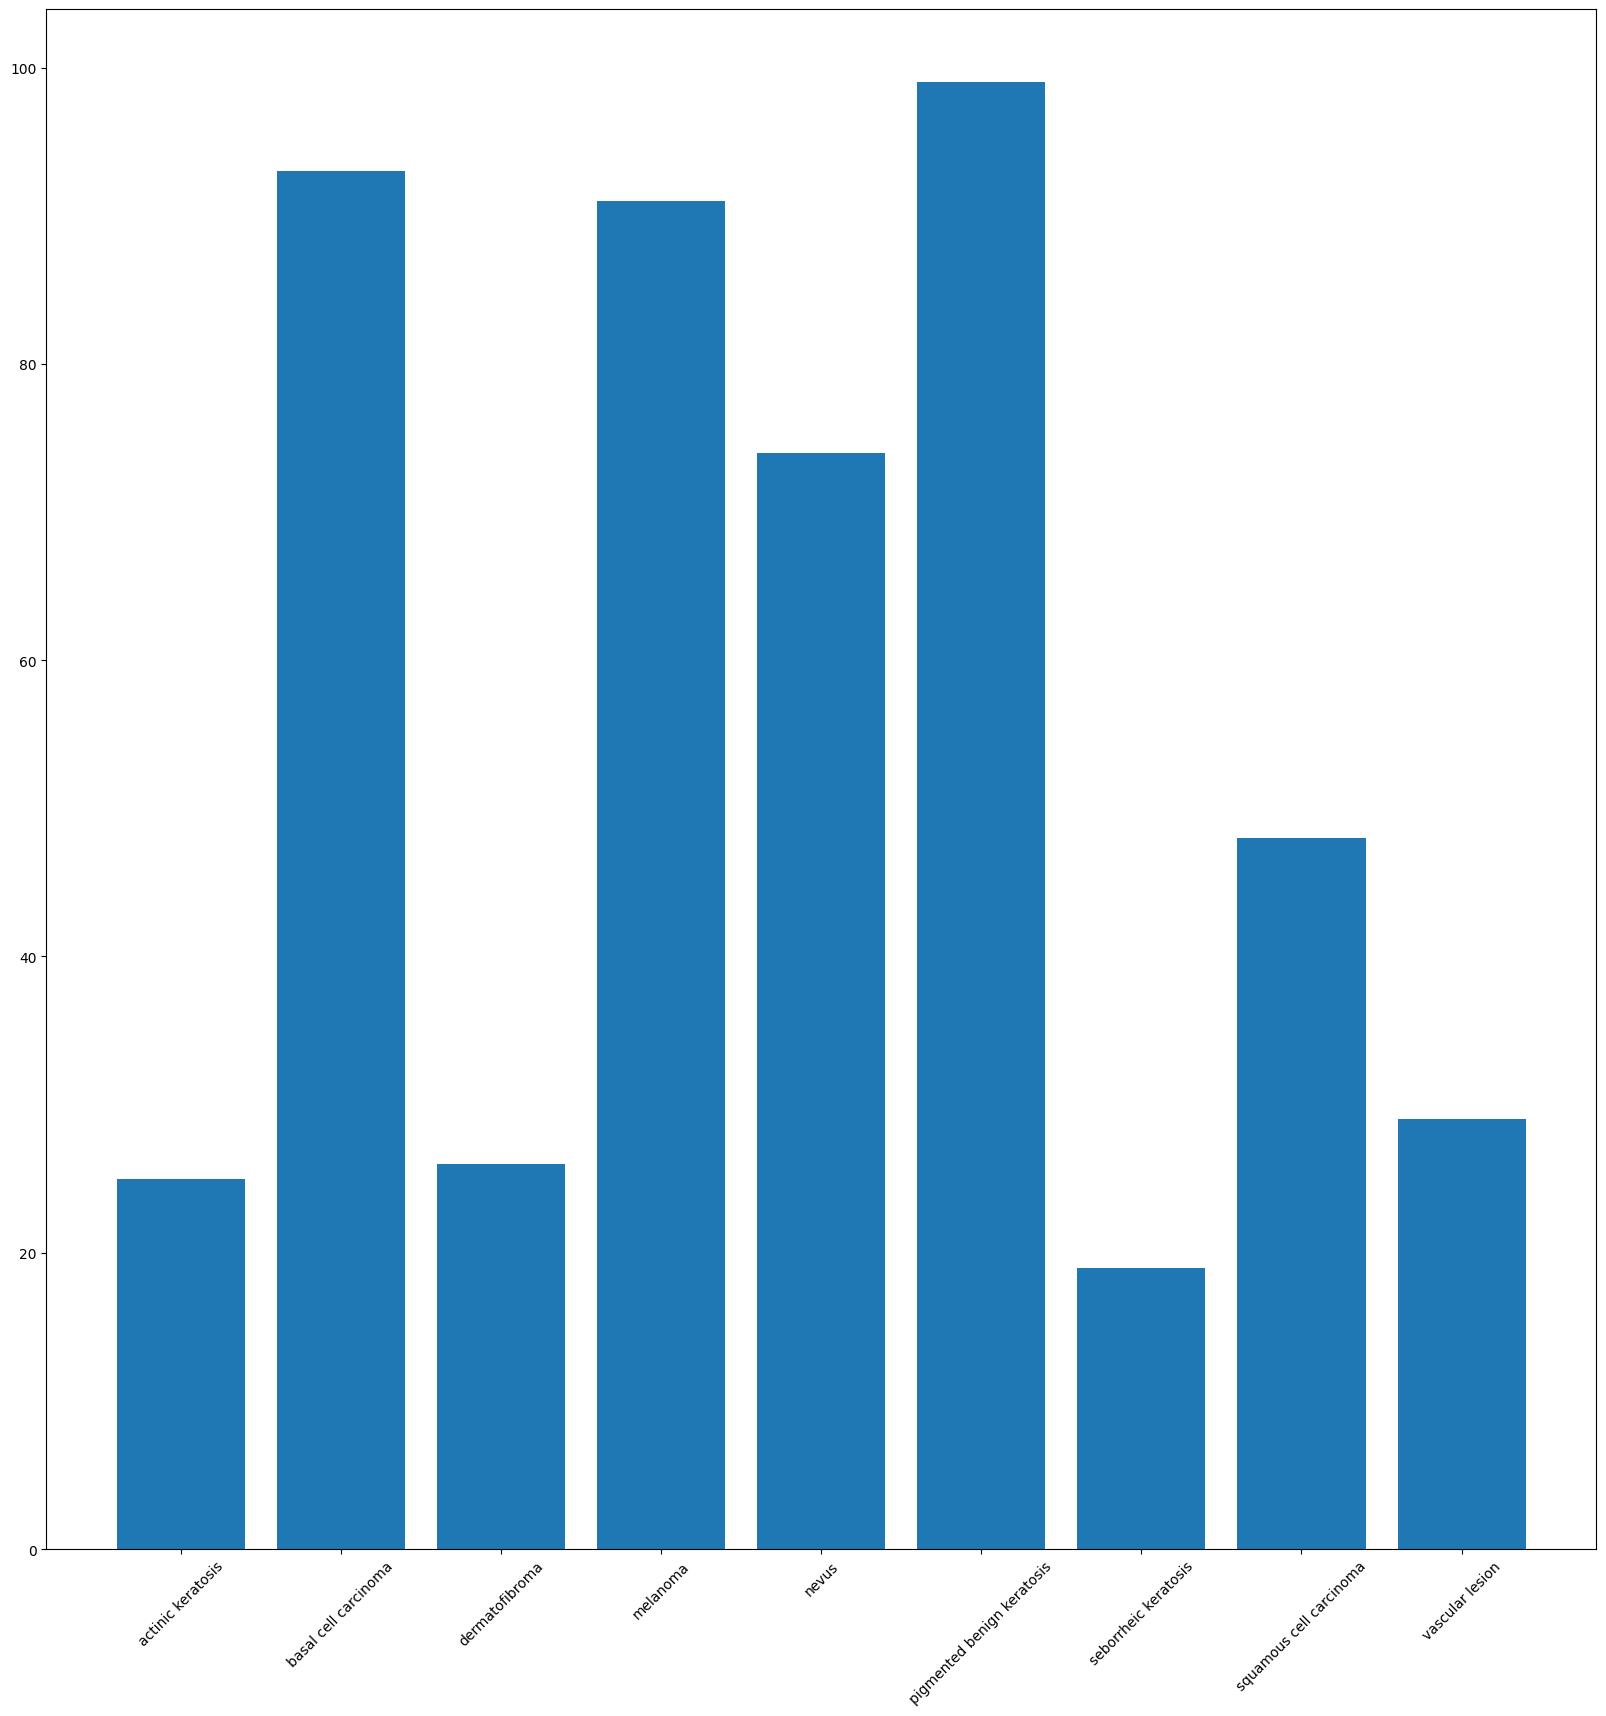

In [23]:
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i])

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()),rotation=45)
plt.show()

#### **Todo:** Write your findings here:

#### - Which class has the least number of samples?
> *seborrheic keratosis is the least number of samples*
#### - Which classes dominate the data in terms proportionate number of samples?
> *pigmented benign keratosis, basal cell carcinoma and melanoma dominate the data in terms proportionate number of samples*


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [24]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
import os
data = []
root = '/content/drive/MyDrive/CNN_assignment/Skin_cancer_ISIC/Train'
classes = os.listdir(root)
for each_class in classes:
  path = root + '/' + each_class
  number_of_imgs = len(os.listdir(path))
  data.append(number_of_imgs)

In [28]:
data_len_dict= dict(zip(class_name, data))
data_len_dict

{'actinic keratosis': 77,
 'basal cell carcinoma': 438,
 'dermatofibroma': 139,
 'melanoma': 114,
 'nevus': 376,
 'pigmented benign keratosis': 181,
 'seborrheic keratosis': 357,
 'squamous cell carcinoma': 462,
 'vascular lesion': 95}

In [30]:
path_to_training_dataset="drive/MyDrive/CNN_assignment/Skin_cancer_ISIC/Train/"
import Augmentor
aug_class = []
for i in class_names:
    n = max(data) - data_len_dict[i] #I address data imbalance by augmenting the classes with fewer samples through the addition of more data
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
    p.sample(500+n)

Initialised with 114 image(s) found.
Output directory set to drive/MyDrive/CNN_assignment/Skin_cancer_ISIC/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x783AEF06A410>: 100%|██████████| 885/885 [00:26<00:00, 32.87 Samples/s]


Initialised with 376 image(s) found.
Output directory set to drive/MyDrive/CNN_assignment/Skin_cancer_ISIC/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x783A6E2F29E0>: 100%|██████████| 524/524 [00:16<00:00, 32.26 Samples/s]


Initialised with 95 image(s) found.
Output directory set to drive/MyDrive/CNN_assignment/Skin_cancer_ISIC/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x783A6E395DE0>: 100%|██████████| 823/823 [00:28<00:00, 28.47 Samples/s]


Initialised with 438 image(s) found.
Output directory set to drive/MyDrive/CNN_assignment/Skin_cancer_ISIC/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x783AEF027F40>: 100%|██████████| 848/848 [01:50<00:00,  7.67 Samples/s]


Initialised with 357 image(s) found.
Output directory set to drive/MyDrive/CNN_assignment/Skin_cancer_ISIC/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x783AEC15AF20>: 100%|██████████| 586/586 [01:10<00:00,  8.33 Samples/s]


Initialised with 462 image(s) found.
Output directory set to drive/MyDrive/CNN_assignment/Skin_cancer_ISIC/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x783AD01C0DC0>: 100%|██████████| 781/781 [00:23<00:00, 33.44 Samples/s]


Initialised with 77 image(s) found.
Output directory set to drive/MyDrive/CNN_assignment/Skin_cancer_ISIC/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x783AEF00C460>: 100%|██████████| 605/605 [00:36<00:00, 16.70 Samples/s]


Initialised with 181 image(s) found.
Output directory set to drive/MyDrive/CNN_assignment/Skin_cancer_ISIC/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x783AEF00CEE0>: 100%|██████████| 500/500 [00:14<00:00, 33.35 Samples/s]


Initialised with 139 image(s) found.
Output directory set to drive/MyDrive/CNN_assignment/Skin_cancer_ISIC/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x783AEC1285B0>: 100%|██████████| 867/867 [00:26<00:00, 32.60 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

6419


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/CNN_assignment/Skin_cancer_ISIC/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010812.jpg_a80ae71c-9ee6-4c18-9f91-a7e1e3411d90.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin_cancer_ISIC/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011031.jpg_c524aaf6-a7e8-4a93-aae3-78c5a4272718.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin_cancer_ISIC/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011187.jpg_22f34176-8f81-45f6-9122-2e586f30e063.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin_cancer_ISIC/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011151.jpg_efb3c2d5-b154-44e0-93f7-f4147828d9ac.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin_cancer_ISIC/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011042.jpg_5284baf4-4531-4502-88c7-7aa466e798f3.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin_cancer_ISIC/Train/seborrheic keratosis/output/sebo

In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [36]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [38]:
df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [39]:
df['Label'].value_counts()

Label
actinic keratosis             885
vascular lesion               867
melanoma                      848
dermatofibroma                823
pigmented benign keratosis    781
seborrheic keratosis          605
nevus                         586
basal cell carcinoma          524
squamous cell carcinoma       500
Name: count, dtype: int64

#### **Todo**: Train the model on the data created using Augmentor

In [40]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [41]:
data_dir_train="/content/drive/MyDrive/CNN_assignment/Skin_cancer_ISIC/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8658 files belonging to 9 classes.
Using 6927 files for training.


#### **Todo:** Create a validation dataset

In [42]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8658 files belonging to 9 classes.
Using 1731 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [43]:
input_shape = (img_height, img_width,3)
def CustomModel(inputshape):
  model = Sequential()
  model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape))
  # Block1
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))

  # Block2
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))

  # Block3
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
  model.add(MaxPool2D(pool_size=(2, 2)))

  # Block 4
  model.add(Conv2D(256, (3, 3), activation='relu'))
  model.add(Conv2D(256, (3, 3), activation='relu'))
  model.add(Dropout(0.25))
  model.add(MaxPool2D((2, 2), strides=(2, 2)))

  # Dense layers
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(9))
  model.add(Activation('softmax'))
  return model

my_model = CustomModel(input_shape)
# Display the model summary
my_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_38 (ModuleW  (None, 178, 178, 32)      896       
 rapper)                                                         
                                                                 
 module_wrapper_39 (ModuleW  (None, 176, 176, 32)      9248      
 rapper)                                                         
                                                                 
 module_wrapper_40 (ModuleW  (None, 88, 88, 32)        0         
 rapper)                                                         
                                                                 
 module_wrapper_41 (ModuleW  (None, 86, 86, 64)        18496     
 rapper)                                              

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [44]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
my_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

#### **Todo:**  Train your model

In [45]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)
epochs = 50
history = my_model.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])

Epoch 1/50
217/217 [==============================] - 69s 277ms/step - loss: 1.9610 - accuracy: 0.2932 - val_loss: 2.3689 - val_accuracy: 0.1415 - lr: 0.0010
Epoch 2/50
217/217 [==============================] - 56s 253ms/step - loss: 1.5861 - accuracy: 0.4033 - val_loss: 1.9173 - val_accuracy: 0.2750 - lr: 0.0010
Epoch 3/50
217/217 [==============================] - 56s 251ms/step - loss: 1.4847 - accuracy: 0.4360 - val_loss: 2.7668 - val_accuracy: 0.1560 - lr: 0.0010
Epoch 4/50
217/217 [==============================] - 57s 253ms/step - loss: 1.4037 - accuracy: 0.4683 - val_loss: 4.9885 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 5/50
217/217 [==============================] - ETA: 0s - loss: 1.3331 - accuracy: 0.5011
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
217/217 [==============================] - 59s 267ms/step - loss: 1.3331 - accuracy: 0.5011 - val_loss: 9.6903 - val_accuracy: 0.1843 - lr: 0.0010
Epoch 6/50
217/217 [=============================

#### **Todo:**  Visualize the model results

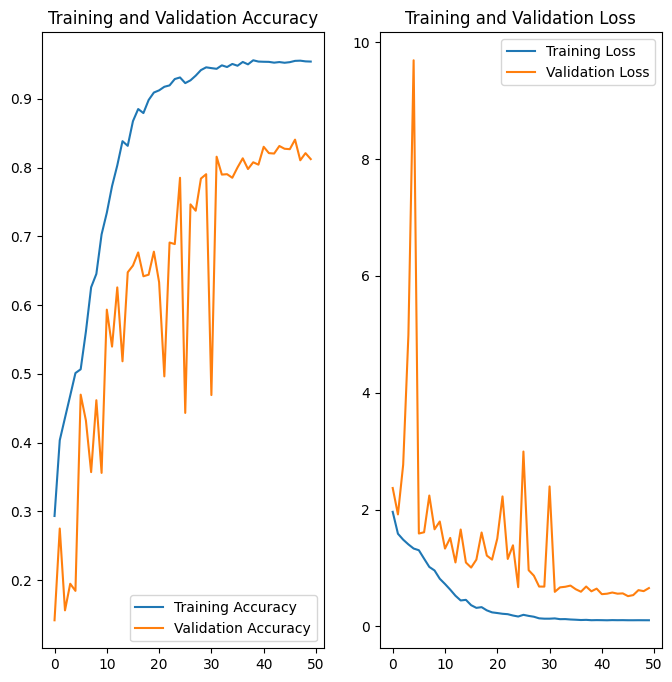

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
> *As the result, the model demonstrates proficient learning with no signs of underfitting or overfitting. The rebalancing of classes contributes significantly to enhancing accuracy.*

